# Spin test 2

In [81]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import ast

Import video

In [82]:
video_number = "7"
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / f"recording_{video_number}" / f"Recording_{video_number}.mp4" 
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 59.94018018162597, Total Frames: 332.0


Import data

In [83]:
# Define the path to the CSV file
# input_data_path = project_root / "notebook" / "ball_detection" / "intermediate_data" / f"Circle_positions_cleaned_{video_number}.csv"
input_data_path = project_root / "data" / "auxiliary_data" / "circle_positions" / f"Adjusted_positions_{video_number}.csv"
# Load the CSV file into a DataFrame
ball_df = pd.read_csv(input_data_path)


new_df = pd.DataFrame(columns=['frame', 'x', 'y', 'radius'])
new_df['frame'] = range(0, ball_df.iloc[len(ball_df)-1]['frame'])
# Assign values from ball_df to new_df where the 'frame' matches
new_df.update(ball_df.set_index('frame'))
ball_df = new_df.copy()
print(ball_df.iloc[-1])

frame        208
x         1408.0
y          198.0
radius      18.0
Name: 208, dtype: object


Select a Frame

In [84]:
# Set the video to the 30th frame (frame index starts from 0)
frame_number = 83
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame = cap.read()

# Check if the frame was successfully read
if ret:
    print(f"Frame {frame_number} successfully read.")
else:
    print(f"Failed to read frame {frame_number}.")

Frame 83 successfully read.


Optical flow

83 83
78 78


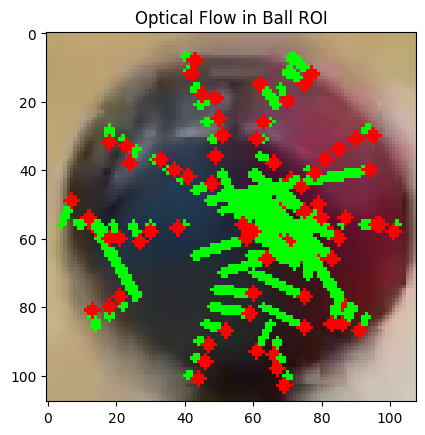

In [85]:
# Extract ball center and radius from ball_df

ball_center = (int(ball_df.iloc[frame_number]['x']), int(ball_df.iloc[frame_number]['y']))
ball_radius = int(ball_df.iloc[frame_number]['radius'])

offset = 2

# Define the region of interest (ROI) around the ball
x_min = max(ball_center[0] - ball_radius, 0)-offset
x_max = min(ball_center[0] + ball_radius, frame.shape[1])+offset
y_min = max(ball_center[1] - ball_radius, 0)-offset
y_max = min(ball_center[1] + ball_radius, frame.shape[0])+offset
roi = frame[y_min:y_max, x_min:x_max]
copy_roi = roi.copy()
ball_center_roi = (ball_center[0] - x_min+offset, ball_center[1] - y_min+offset)
# Convert ROI to grayscale
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

# Parameters for optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# selezione 100 punti manuali distribuiti su 10 cerchi concentrici
manual_points = []
num_rings = 10  # numero di cerchi concentrici
points_per_ring = 10  # punti per ogni cerchio (10 × 10 = 100)
max_radius = ball_radius * 0.99  # lascia un margine vicino al bordo

for i in range(1, num_rings + 1):
    r = (i / num_rings) * max_radius
    for j in range(points_per_ring):
        if j<20 or j>9:
            theta = 2 * np.pi * j / points_per_ring
            x = int(ball_center_roi[0] + r * np.cos(theta))
            y = int(ball_center_roi[1] + r * np.sin(theta))
            manual_points.append((x, y))

# Converti in formato richiesto da calcOpticalFlowPyrLK
p0 = np.array(manual_points, dtype=np.float32).reshape(-1, 1, 2)

# Read the next frame for optical flow calculation
ret, next_frame = cap.read()
if not ret:
    raise ValueError(f"Failed to read the next frame after frame {frame_number}.")

# calculate the next ball center
ball_center_next = (int(ball_df.iloc[frame_number + 1]['x']), int(ball_df.iloc[frame_number + 1]['y']))
# as radius I need to use the previous in ordet to have roi of the same size

# Define the next ROI around the ball in the next frame
x_min_next = max(ball_center_next[0] - ball_radius, 0)-offset
x_max_next = min(ball_center_next[0] + ball_radius, next_frame.shape[1])+offset
y_min_next = max(ball_center_next[1] - ball_radius, 0)-offset
y_max_next = min(ball_center_next[1] + ball_radius, next_frame.shape[0])+offset
next_roi = next_frame[y_min_next:y_max_next, x_min_next:x_max_next]
ball_center_next_roi = (ball_center_next[0] - x_min_next, ball_center_next[1] - y_min_next)

next_roi_gray = cv2.cvtColor(next_roi, cv2.COLOR_BGR2GRAY)

# Calculate optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(roi_gray, next_roi_gray, p0, None, **lk_params)

# store the flow vectors
flow_vectors = [] 

# Filter good points
if p1 is not None and st is not None:
    # # get the indeces where st==1 and err<10 -> more filtering
    # good_indices = np.where((st.flatten() == 1) & (err < 20))[0]
    # good_new = p1[good_indices].reshape(-1, 2)
    # good_old = p0[good_indices].reshape(-1, 2)
    # err_good = err[good_indices]
    # print(good_indices)

    good_new = p1[st == 1].reshape(-1, 2)
    good_old = p0[st == 1].reshape(-1, 2)
    print(len(good_new), len(good_old))

    # Filter only the point in the ball
    # Compute distances to the ball center
    dist_old = np.linalg.norm(good_old[:, :] - ball_center_roi, axis=1)
    dist_new = np.linalg.norm(good_new[:, :] - ball_center_next_roi, axis=1)

    # Create a mask of points that are within the ball in both frames
    within_radius_mask = (dist_old <= ball_radius) & (dist_new <= ball_radius)

    # Apply the mask
    good_old = good_old[within_radius_mask].reshape(-1, 2)
    good_new = good_new[within_radius_mask].reshape(-1, 2)

    print(len(good_new), len(good_old))


    # Visualize the optical flow
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        cv2.line(roi, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
        cv2.circle(roi, (int(a), int(b)), 2, (0, 0, 255), -1)
        flow_vectors.append({
            'frame': frame_number,
            'point_id': i,
            'x_old': c,
            'y_old': d,
            'x_new': a,
            'y_new': b,
            'dx': a - c,
            'dy': b - d
        })
        # print(f"Point {i}: Old: ({c}, {d}), New: ({a}, {b}), dx: {a - c}, dy: {b - d}")

    # Display the ROI with optical flow
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.title("Optical Flow in Ball ROI")
    plt.show()
else:
    print("No optical flow points detected.")

Compute rotation and axis

In [86]:
distances = np.linalg.norm(good_new - good_old, axis=1)
velocities = distances / (1 / cap.get(cv2.CAP_PROP_FPS))  # Convert to velocity in pixels per second
z_3d_old = np.sqrt(ball_radius**2 - (good_old[:, 0]-ball_center_roi[0])**2 - (good_old[:, 1]-ball_center_roi[1])**2)
points_3d_old = np.array([good_old[:, 0], good_old[:, 1], z_3d_old]).T

z_3d_new = np.sqrt(ball_radius**2 - (good_new[:, 0]-ball_center_next_roi[0])**2 - (good_new[:, 1]-ball_center_next_roi[1])**2)
points_3d_new = np.array([good_new[:, 0], good_new[:, 1], z_3d_new]).T

# Calculate the 3D velocity vectors
velocity_vectors_3d = points_3d_new - points_3d_old


In [87]:
'''for each point in points_3d_new, calculate its projection on the plane tangen to the ball surface 
    in the corrspondent poin in points_3d_old
the projection is done by calculating the normal vector to the ball surface in the point of interest and 
    then projecting the point on this plane
the normal vector is given by the vector from the center of the ball to the point of interest
'''
# normal vectors to the ball surface in the point of interest
normal_vectors = points_3d_old / np.linalg.norm(points_3d_old, axis=1)[:, np.newaxis]  

# projection of the points on the plane tangent to the ball surface in the point of interest (they are the difference, not the points)
projection_vectors = points_3d_new - np.sum(points_3d_new * normal_vectors, axis=1)[:, np.newaxis] * normal_vectors
# print(projection_vectors)

projected_points_new = points_3d_old + projection_vectors




In [88]:
def estimate_rotation_matrix(P, Q):
    """
    Estimate rotation matrix that aligns P to Q (P and Q are Nx3)
    """
    assert P.shape == Q.shape
    centroid_P = np.mean(P, axis=0)
    centroid_Q = np.mean(Q, axis=0)
    
    # Center the points
    P_centered = P - centroid_P
    Q_centered = Q - centroid_Q
    
    # Compute covariance matrix
    H = P_centered.T @ Q_centered

    # SVD
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Handle reflection (if determinant is negative)
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = Vt.T @ U.T

    return R

R = estimate_rotation_matrix(points_3d_old, projected_points_new)
print("Rotation matrix:\n", R)
# Calculate the rotation angles around each axis (in radians)
angles = np.arctan2(R[2, 1], R[2, 2]), np.arctan2(-R[2, 0], np.sqrt(R[2, 1]**2 + R[2, 2]**2)), np.arctan2(R[1, 0], R[0, 0])
angles_deg = np.degrees(angles)  # convert to degrees
print("Rotation angles (degrees):", angles_deg)

# Compute the angular velocity vector (in radiant per second)
angular_velocity = np.array([angles[0], angles[1], angles[2]]) / (1 / cap.get(cv2.CAP_PROP_FPS))  # Convert to angular velocity in degrees per second
print("Angular velocity (rad/s):", angular_velocity)

# compute the vector magnitude
angular_velocity_magnitude = np.linalg.norm(angular_velocity)
print("Angular velocity magnitude (rad/s):", angular_velocity_magnitude)

# Compute the axis of rotation (in 3D space)
axis_of_rotation = np.cross(points_3d_old.mean(axis=0), projected_points_new.mean(axis=0))
print("Axis of rotation (3D):", axis_of_rotation)

# Compute the intersection of the axis of rotation with the ball surface
# Normalize the axis of rotation
axis_of_rotation_normalized = axis_of_rotation / np.linalg.norm(axis_of_rotation)
# Compute the intersection point on the ball surface
intersection_point_1 = ball_radius * axis_of_rotation_normalized
intersection_point_2 = - ball_radius * axis_of_rotation_normalized 

# I want to chose the intersection point that has positive z coordinate
intersection_point = intersection_point_1 if intersection_point_1[2] > 0 else intersection_point_2
print("Intersection point on the ball surface (3D):", intersection_point)

# Get the intersection point in 2D:
intersection_point_2d = intersection_point[:2] + ball_center_roi
print("Intersection point on the ball surface (2D):", intersection_point_2d)

Rotation matrix:
 [[ 0.9827588  -0.00395973  0.1848498 ]
 [-0.01200492  0.9962944   0.08516646]
 [-0.18450205 -0.0859172   0.9790696 ]]
Rotation angles (degrees): [-5.015083  10.632102  -0.6998633]
Angular velocity (rad/s): [-5.2465467 11.122811  -0.7321645]
Angular velocity magnitude (rad/s): 12.319872
Axis of rotation (3D): [-181.27942  291.00708 -141.45093]
Intersection point on the ball surface (3D): [ 25.416311 -40.800697  19.832151]
Intersection point on the ball surface (2D): [81.41631126 15.19930267]


Generate video

In [89]:
from scipy.spatial.transform import Rotation


output_video_path = project_root / "data" / f"recording_{video_number}" / "test_video" / f"spin_video_modified_{video_number}.mp4"

# Ottieni le proprietà del video originale
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Inizializza il VideoWriter
out = cv2.VideoWriter(str(output_video_path), fourcc, fps, (frame_width, frame_height))

# Riposiziona il video all'inizio
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Itera su tutti i frame del video
frame_idx = 0
while True:
# for i in range(151):
    ret, frame = cap.read()
    if not ret:
        break

    # Controlla se il dato radius è presente per il frame corrente
    if frame_idx < ball_df['frame'].iloc[-1]:
        if not pd.isna(ball_df.iloc[frame_idx]['radius']) and not pd.isna(ball_df.iloc[frame_idx+1]['radius']):
        # Extract ball center and radius from ball_df
            ball_center = (int(ball_df.iloc[frame_idx]['x']), int(ball_df.iloc[frame_idx]['y']))
            ball_radius = int(ball_df.iloc[frame_idx]['radius'])

            offset = 2

            # Define the region of interest (ROI) around the ball
            x_min = max(ball_center[0] - ball_radius, 0)-offset
            x_max = min(ball_center[0] + ball_radius, frame.shape[1])+offset
            y_min = max(ball_center[1] - ball_radius, 0)-offset
            y_max = min(ball_center[1] + ball_radius, frame.shape[0])+offset
            roi = frame[y_min:y_max, x_min:x_max]
            copy_roi = roi.copy()
            ball_center_roi = (ball_center[0] - x_min+offset, ball_center[1] - y_min+offset)
            # Convert ROI to grayscale
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

            # Parameters for optical flow
            lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

            # selezione 100 punti manuali distribuiti su 10 cerchi concentrici
            manual_points = []
            num_rings = 10  # numero di cerchi concentrici
            points_per_ring = 10  # punti per ogni cerchio (10 × 10 = 100)
            max_radius = ball_radius * 0.9  # lascia un margine vicino al bordo

            for i in range(1, num_rings + 1):
                r = (i / num_rings) * max_radius
                for j in range(points_per_ring):
                    if j<20 or j>9:
                        theta = 2 * np.pi * j / points_per_ring
                        x = int(ball_center_roi[0] + r * np.cos(theta))
                        y = int(ball_center_roi[1] + r * np.sin(theta))
                        manual_points.append((x, y))

            # Converti in formato richiesto da calcOpticalFlowPyrLK
            p0 = np.array(manual_points, dtype=np.float32).reshape(-1, 1, 2)

            # Calcola il flusso ottico per il frame corrente
            if frame_idx + 1 < len(ball_df):
                # print(f"Processing frame {frame_idx}...")
                ball_center_next = (int(ball_df.iloc[frame_idx + 1]['x']), int(ball_df.iloc[frame_idx + 1]['y']))
                x_min_next = max(ball_center_next[0] - ball_radius, 0) - offset
                x_max_next = min(ball_center_next[0] + ball_radius, frame.shape[1]) + offset
                y_min_next = max(ball_center_next[1] - ball_radius, 0) - offset
                y_max_next = min(ball_center_next[1] + ball_radius, frame.shape[0]) + offset
                next_roi = next_frame[y_min_next:y_max_next, x_min_next:x_max_next]
                next_roi_gray = cv2.cvtColor(next_roi, cv2.COLOR_BGR2GRAY)
                ball_center_next_roi = (ball_center_next[0] - x_min_next, ball_center_next[1] - y_min_next)

                # Calcola il flusso ottico
                p1, st, err = cv2.calcOpticalFlowPyrLK(roi_gray, next_roi_gray, p0, None, **lk_params)

                # Filtra i punti validi
                if p1 is not None and st is not None:
                    good_new = p1[st == 1].reshape(-1, 2)
                    good_old = p0[st == 1].reshape(-1, 2)

                    # Filter only the point in the ball
                    # Compute distances to the ball center
                    dist_old = np.linalg.norm(good_old[:, :] - ball_center_roi, axis=1)
                    dist_new = np.linalg.norm(good_new[:, :] - ball_center_next_roi, axis=1)

                    # Create a mask of points that are within the ball in both frames
                    within_radius_mask = (dist_old <= ball_radius) & (dist_new <= ball_radius)

                    # Apply the mask
                    good_old = good_old[within_radius_mask].reshape(-1, 2)
                    good_new = good_new[within_radius_mask].reshape(-1, 2)

                    distances = np.linalg.norm(good_new - good_old, axis=1)
                    velocities = distances / (1 / cap.get(cv2.CAP_PROP_FPS))  # Convert to velocity in pixels per second
                    z_3d_old = np.sqrt(ball_radius**2 - (good_old[:, 0]-ball_center_roi[0])**2 - (good_old[:, 1]-ball_center_roi[1])**2)
                    points_3d_old = np.array([good_old[:, 0], good_old[:, 1], z_3d_old]).T

                    z_3d_new = np.sqrt(ball_radius**2 - (good_new[:, 0]-ball_center_next_roi[0])**2 - (good_new[:, 1]-ball_center_next_roi[1])**2)
                    points_3d_new = np.array([good_new[:, 0], good_new[:, 1], z_3d_new]).T

                    distances_3d = np.linalg.norm(points_3d_new - points_3d_old, axis=1)

                    # normal vectors to the ball surface in the point of interest
                    normal_vectors = points_3d_old / np.linalg.norm(points_3d_old, axis=1)[:, np.newaxis]  

                    # projection of the points on the plane tangent to the ball surface in the point of interest (they are the difference, not the points)
                    projection_vectors = points_3d_new - np.sum(points_3d_new * normal_vectors, axis=1)[:, np.newaxis] * normal_vectors
                    # print(projection_vectors)
                    # normalize the projection vectors
                    projection_vectors = projection_vectors / np.linalg.norm(projection_vectors, axis=1)[:, np.newaxis]
                    # multiply the projection vectors by the distances_3d to make them have the same magnitude
                    projection_vectors = projection_vectors * distances_3d[:, np.newaxis]

                    projected_points_new = points_3d_old + projection_vectors

                    R = estimate_rotation_matrix(points_3d_old, points_3d_new) ## CHANEG points_3d_new to projected_points_new

                    # DA LIBRERIA
                    rot = Rotation.from_matrix(R)
                    axis_of_rotation_normalized = rot.as_rotvec()/np.linalg.norm(rot.as_rotvec())

                    # Compute the intersection point on the ball surface
                    intersection_point_1 = ball_radius * axis_of_rotation_normalized
                    intersection_point_2 = - ball_radius * axis_of_rotation_normalized 

                    # I want to chose the intersection point that has positive z coordinate
                    intersection_point = intersection_point_1 if intersection_point_1[2] > 0 else intersection_point_2
                    behind_point = intersection_point_2 if intersection_point_1[0] == intersection_point[0] else intersection_point_1
                    print("frame:", frame_idx ,"Intersection point:", intersection_point)

                    # Get the intersection point in 2D:
                    intersection_point_2d = intersection_point[:2] + ball_center
                    behind_point = behind_point[:2] + ball_center
                    # print("frame:", frame_idx ,"Intersection point:", intersection_point_2d)

                    # Add the intersection point to ball_df
                    ball_df.loc[frame_idx, 'rotation_center_x'] = intersection_point_2d[0]
                    ball_df.loc[frame_idx, 'rotation_center_y'] = intersection_point_2d[1]

                    # Disegna il centro della palla
                    # cv2.circle(frame, ball_center, 5, (255, 0, 0), -1) # Blu
                    
                    if not np.isnan(intersection_point_2d[0]) and not np.isnan(intersection_point_2d[1]):
                        rotation_point_2d = (int(intersection_point_2d[0]), int(intersection_point_2d[1]))
                        back_point = (int(behind_point[0]), int(behind_point[1]))
                        # Disegna il centro di rotazione
                        cv2.circle(frame, rotation_point_2d, 5, (0, 255, 255), -1)  # Giallo
                        cv2.circle(frame, back_point, 5, (0, 255, 255), -1) 
                        cv2.line(frame, rotation_point_2d, back_point, (144, 238, 144), 1)  # Draw a light green thin line
                        # print(f"Frame {frame_idx}: Center of Rotation: {rotation_point_2d}")

    # Scrivi il frame nel video di output
    out.write(frame)

    # Incrementa l'indice del frame
    frame_idx += 1

# Rilascia le risorse
out.release()

print(f"Video annotato salvato in: {output_video_path}")

C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\miche\AppData\Local\Temp\ipykernel_13928\1302648906.py:126: RuntimeWarning: invalid value encountered in divide
  axis_of_rotation_normalized = rot.as_rotvec()/np.linalg.norm(rot.as_rotvec())
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packag

frame: 70 Intersection point: [nan nan nan]
frame: 71 Intersection point: [nan nan nan]
frame: 72 Intersection point: [nan nan nan]
frame: 73 Intersection point: [nan nan nan]
frame: 74 Intersection point: [nan nan nan]
frame: 75 Intersection point: [nan nan nan]
frame: 76 Intersection point: [nan nan nan]
frame: 77 Intersection point: [29.27069746 33.68399125 35.46286796]
frame: 78 Intersection point: [-10.69425438  20.29206777  51.08683694]
frame: 79 Intersection point: [-53.25322769 -13.29473088   3.51338464]
frame: 80 Intersection point: [42.92951898 21.84604771 24.40914991]
frame: 81 Intersection point: [25.46026634 42.1456503  19.60915599]
frame: 82 Intersection point: [10.30459206 50.8678218   3.20625756]
frame: 83 Intersection point: [-31.42098025  41.38175519   2.06696331]
frame: 84 Intersection point: [-49.03232269 -12.69168849   5.97932899]
frame: 85 Intersection point: [-35.16951505 -34.67518502   7.79337892]
frame: 86 Intersection point: [-36.30299151 -28.81800621  15.8938

C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\miche\AppData\Local\Temp\ipykernel_13928\1302648906.py:126: RuntimeWarning: invalid value encountered in divide
  axis_of_rotation_normalized = rot.as_rotvec()/np.linalg.norm(rot.as_rotvec())
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packag

frame: 97 Intersection point: [nan nan nan]
frame: 98 Intersection point: [nan nan nan]
frame: 99 Intersection point: [nan nan nan]
frame: 100 Intersection point: [nan nan nan]
frame: 101 Intersection point: [nan nan nan]
frame: 102 Intersection point: [nan nan nan]
frame: 103 Intersection point: [nan nan nan]
frame: 104 Intersection point: [nan nan nan]
frame: 105 Intersection point: [nan nan nan]
frame: 106 Intersection point: [nan nan nan]
frame: 107 Intersection point: [nan nan nan]
frame: 108 Intersection point: [nan nan nan]
frame: 109 Intersection point: [nan nan nan]
frame: 110 Intersection point: [nan nan nan]
frame: 111 Intersection point: [nan nan nan]
frame: 112 Intersection point: [nan nan nan]


C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\miche\AppData\Local\Temp\ipykernel_13928\1302648906.py:126: RuntimeWarning: invalid value encountered in divide
  axis_of_rotation_normalized = rot.as_rotvec()/np.linalg.norm(rot.as_rotvec())
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packag

frame: 113 Intersection point: [nan nan nan]
frame: 114 Intersection point: [nan nan nan]
frame: 115 Intersection point: [nan nan nan]
frame: 116 Intersection point: [nan nan nan]
frame: 117 Intersection point: [nan nan nan]
frame: 118 Intersection point: [nan nan nan]
frame: 119 Intersection point: [nan nan nan]
frame: 120 Intersection point: [nan nan nan]
frame: 121 Intersection point: [nan nan nan]
frame: 122 Intersection point: [nan nan nan]
frame: 123 Intersection point: [nan nan nan]
frame: 124 Intersection point: [nan nan nan]
frame: 125 Intersection point: [nan nan nan]
frame: 126 Intersection point: [nan nan nan]
frame: 127 Intersection point: [nan nan nan]
frame: 128 Intersection point: [nan nan nan]


C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\miche\AppData\Local\Temp\ipykernel_13928\1302648906.py:126: RuntimeWarning: invalid value encountered in divide
  axis_of_rotation_normalized = rot.as_rotvec()/np.linalg.norm(rot.as_rotvec())
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packag

frame: 129 Intersection point: [nan nan nan]
frame: 130 Intersection point: [nan nan nan]
frame: 131 Intersection point: [nan nan nan]
frame: 132 Intersection point: [nan nan nan]
frame: 133 Intersection point: [nan nan nan]
frame: 134 Intersection point: [nan nan nan]
frame: 135 Intersection point: [-17.56713864  16.63343778  11.98851065]
frame: 136 Intersection point: [ 12.59009656 -17.63709137  16.1065973 ]
frame: 137 Intersection point: [ 7.21370367 -3.23148286 25.81704859]
frame: 138 Intersection point: [nan nan nan]
frame: 139 Intersection point: [nan nan nan]
frame: 140 Intersection point: [10.20983079 23.28387356  5.44247987]
frame: 141 Intersection point: [24.45265093  8.65868121  1.75929018]
frame: 142 Intersection point: [21.55960294  0.28852352 14.52929026]
frame: 143 Intersection point: [nan nan nan]
frame: 144 Intersection point: [nan nan nan]


C:\Users\miche\AppData\Local\Temp\ipykernel_13928\1302648906.py:126: RuntimeWarning: invalid value encountered in divide
  axis_of_rotation_normalized = rot.as_rotvec()/np.linalg.norm(rot.as_rotvec())
C:\Users\miche\AppData\Local\Temp\ipykernel_13928\1302648906.py:126: RuntimeWarning: invalid value encountered in divide
  axis_of_rotation_normalized = rot.as_rotvec()/np.linalg.norm(rot.as_rotvec())
C:\Users\miche\AppData\Local\Temp\ipykernel_13928\1302648906.py:126: RuntimeWarning: invalid value encountered in divide
  axis_of_rotation_normalized = rot.as_rotvec()/np.linalg.norm(rot.as_rotvec())
C:\Users\miche\AppData\Local\Temp\ipykernel_13928\1302648906.py:126: RuntimeWarning: invalid value encountered in divide
  axis_of_rotation_normalized = rot.as_rotvec()/np.linalg.norm(rot.as_rotvec())
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of 

frame: 145 Intersection point: [nan nan nan]
frame: 146 Intersection point: [nan nan nan]
frame: 147 Intersection point: [nan nan nan]
frame: 148 Intersection point: [12.38554771 16.1303662  14.53992759]
frame: 149 Intersection point: [-11.70109641  19.87049515   6.65189938]
frame: 150 Intersection point: [-10.62089395   9.04915521  19.52714525]
frame: 151 Intersection point: [21.60352649 -8.96073435  5.38450398]
frame: 152 Intersection point: [-23.47541804   4.67504567   1.74605145]
frame: 153 Intersection point: [-19.93215149  -4.77275338  12.48719992]
frame: 154 Intersection point: [-23.00910589  -1.38956481   6.68207721]
frame: 155 Intersection point: [21.80182979  6.65094867  3.0732881 ]
frame: 156 Intersection point: [-22.51836933  -4.58726226   0.93811929]
frame: 157 Intersection point: [21.62322242  5.96876333  5.08036579]
frame: 158 Intersection point: [-21.61560949   5.19758815   5.8949558 ]
frame: 159 Intersection point: [-22.79180234   3.0098715    0.68878113]
frame: 160 In

C:\Users\miche\AppData\Local\Temp\ipykernel_13928\1302648906.py:126: RuntimeWarning: invalid value encountered in divide
  axis_of_rotation_normalized = rot.as_rotvec()/np.linalg.norm(rot.as_rotvec())
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\miche\AppData\Local\Temp\ipykernel_13928\1302648906.py:126: RuntimeWarning: invalid value encountered in divide
  axis_of_rotation_normalized = rot.as_rotvec()/np.linalg.norm(rot.as_rotvec())
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

frame: 178 Intersection point: [-16.18605064  10.19226622   5.84204364]
frame: 179 Intersection point: [14.11010171 10.88759813  9.07552955]
frame: 180 Intersection point: [-17.32768939   1.31083178   9.90115652]
frame: 181 Intersection point: [-19.29456899   4.7967639    2.17040634]
frame: 182 Intersection point: [-14.467923    10.32998364   9.16354964]
frame: 183 Intersection point: [ 15.03035371 -12.84642489   3.0096237 ]
frame: 184 Intersection point: [ 14.55943314 -11.48227628   7.49534775]
frame: 185 Intersection point: [17.8579002  -9.00474537  0.09980558]
frame: 186 Intersection point: [-18.44478808   7.34997961   2.40158126]
frame: 187 Intersection point: [-19.37966509   3.20654309   3.76120494]
frame: 188 Intersection point: [-19.20928818   4.31644821   3.51731751]
frame: 189 Intersection point: [19.60988035 -3.9288308   0.12992777]
frame: 190 Intersection point: [18.69961305 -3.24946095  0.87491447]
frame: 191 Intersection point: [-18.59826972   3.64321018   1.35328599]
fram

Save the data in a csv file

In [90]:
output_path = project_root / "notebook" / "spin" / "intermediate_data" / f"Ball_data_{video_number}.csv"
ball_df.to_csv(output_path, index=False)
print(f"Ball data salvato in: {output_path}")

Ball data salvato in: C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\notebook\spin\intermediate_data\Ball_data_7.csv
